In [1]:
import tensorflow as tf
import numpy as np
from nbutil import imshow_multi
import os
from PIL import Image
import urllib, cStringIO
import random

In [2]:
attr_file = '../data/celeba/list_attr_celeba.txt'
keys = None
attributes_by_image = {}
for i, line in enumerate(open(attr_file)):
    if i == 1:
        keys = line.split()
    elif i > 1:
        image = os.path.join('../data/celeba/img_align_celeba', line.split()[0])
        values = line.split()[1:]
        attributes_by_image[image] = {attr: val == '1' for attr, val in zip(keys, values)}

In [3]:
BATCH_SIZE = 16

In [4]:
# filename_queue = tf.train.string_input_producer(image_names, num_epochs=None)
# attr_queue = tf.train.input_producer(tf.constant(attr_vector), num_epochs=None)

def create_qs(image_names):
    filename_tensor = tf.convert_to_tensor(image_names, dtype=tf.string)
    filename_q = tf.train.slice_input_producer([filename_tensor], num_epochs=None, shuffle=True)[0]

    # reader = tf.WholeFileReader()
    # filename, image_data = reader.read(filename_q)
    image_255 = tf.image.decode_jpeg(tf.read_file(filename_q))
    image = tf.reshape(tf.cast(image_255, tf.float32) / 255.0, [218, 178, 3]) # images are 178x218
    image = tf.image.resize_image_with_crop_or_pad(image, 128, 128)

    def distort_image(image):
        noise_amt = tf.abs(tf.pow(tf.random_normal([], stddev=0.1), 2))
        distorted_image = image + tf.random_uniform([128, 128, 3], maxval=noise_amt)
        distorted_image = tf.image.random_flip_left_right(distorted_image)
        distorted_image = tf.image.random_brightness(distorted_image, max_delta=0.3)
        distorted_image = tf.image.random_contrast(distorted_image, lower=0.7, upper=1.3)
        # distorted_image = tf.image.per_image_standardization(distorted_image)
        # distorted_image = tf.clip_by_value(distorted_image, 0, 1)
        return distorted_image

    image = distort_image(image)

    batch = tf.train.shuffle_batch([image], batch_size=BATCH_SIZE, capacity=512, min_after_dequeue=256)
    return tf.image.rgb_to_grayscale(tf.image.resize_bilinear(batch, [64, 64]))

batch = create_qs(attributes_by_image.keys())


In [5]:
session = tf.Session()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
session.run(init_op)
tf.train.start_queue_runners(sess=session)

[<Thread(Thread-4, started daemon 140397338666752)>,
 <Thread(Thread-5, started daemon 140397330274048)>]

(16, 64, 64, 1)


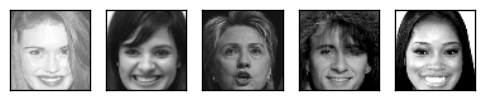

In [6]:
%matplotlib inline

images_ = session.run(batch)
print images_.shape
imshow_multi(np.tile(images_[:5], [1,1,1,3]))

In [7]:
dropout_keep_prob = tf.placeholder_with_default(tf.constant(1.0), [], name='dropout_keep_prob')        
from tensorflow.contrib.layers.python.layers import batch_norm

def relu_fn(x):
    # leaky relu
    alpha = 0.05
    return tf.maximum(alpha*x,x)

keyed_vars = {}
def join_keys(key1, key2):
    if key1 is None or key2 is None:
        return None
    else:
        return key1 + '.' + key2

def weight_var(shape, stddev=0.1, mean=0.0, weight_decay=0, name=None, key=None):
    initial = tf.truncated_normal(shape, mean=mean, stddev=stddev)
    v = tf.Variable(initial, name=name)
    if weight_decay > 0:
        l2 = tf.nn.l2_loss(v) * weight_decay
        tf.add_to_collection('losses', l2)
    if key: keyed_vars[key] = v
    return v

def create_fc(input, out_size, relu=True, key=None):
    # input_dropped = tf.nn.dropout(input, dropout_keep_prob)
    in_size = input.get_shape()[-1].value
    w = weight_var([in_size, out_size], name='w', key=join_keys(key, 'w'))
    b = weight_var([out_size], mean=0.1, name='b', key=join_keys(key, 'b'))
    x = tf.matmul(input, w)
    return relu_fn(x + b) if relu else x + b

def create_conv(input, out_channels, patch_size=5, stride=1, dropout=False, key=None, use_relu=True):
    in_channels = input.get_shape()[-1].value
    w = weight_var([patch_size, patch_size, in_channels, out_channels], name='w', key=join_keys(key, 'w'))
    b = weight_var([out_channels], stddev=0, name='b', mean=0.1, key=join_keys(key, 'b'))
    conv = tf.nn.conv2d(input, w, strides=[1,stride,stride,1], padding='SAME')
    activation = relu_fn(conv + b) if use_relu else conv + b
    if dropout: activation = create_dropout(activation)
    return activation

def create_deconv(input, out_channels, patch_size=5, stride=1, use_relu=True):
    # for best results, patch_size should be a multiple of stride
    input_w, input_h, input_channels = [i.value for i in input.get_shape()[-3:]]
    
    w = weight_var([patch_size, patch_size, out_channels, input_channels])
    b = weight_var([out_channels], mean=0.1)
    
    batch_size = BATCH_SIZE # tf.shape(input)[0]
    output_shape = tf.pack([batch_size, input_w*stride, input_h*stride, out_channels])
    
    deconv = tf.nn.conv2d_transpose(input, w, output_shape, strides=[1,stride,stride,1], padding='SAME')
    
    activation = relu_fn(deconv + b) if use_relu else deconv + b
    return activation

def create_max_pool(inputs, ksize=2, stride=2):
    return tf.nn.max_pool(inputs, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1], padding='SAME')

def create_avg_pool(inputs, ksize=2, stride=2):
    return tf.nn.avg_pool(inputs, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1], padding='SAME')

def create_batch_norm(inputs):
    return batch_norm(inputs, is_training=(MODE == 'TRAIN'), updates_collections=None)

def create_dropout(inputs):
    return tf.nn.dropout(inputs, dropout_keep_prob)

def flatten_tensor(t):
    shape = [s.value for s in t.get_shape()]
    flat_size = 1
    for x in shape[1:]:
        flat_size *= x
    return tf.reshape(t, [-1, flat_size])

In [8]:
def generator(noise, name='generator'):
    with tf.variable_scope(name):
        image = create_fc(noise, 512)
        image = tf.reshape(image, [-1, 4, 4, 32])
        for size, stride, channels in [(4, 2, 32), (4, 2, 32), (4, 2, 32), (4, 2, 1)]:
            image = create_deconv(image, channels, size, stride)
        return image

def discriminator(image, name='discriminator'):
    with tf.variable_scope(name):
        for x in [16, 32, 64]:
            image = create_conv(image, x, patch_size=5)
            image = create_avg_pool(image)
        image = flatten_tensor(image)
        image = create_dropout(image)
        image = create_fc(image, 256)
        return create_fc(image, 2)

noise = tf.placeholder_with_default(tf.random_normal([BATCH_SIZE, 128]), [BATCH_SIZE, 128], name='noise')
generated = generator(noise)
real = batch
real_guess = discriminator(tf.concat(0, [generated, real]))
real_truth = tf.constant([0] * BATCH_SIZE + [1] * BATCH_SIZE)

# generated_difference_loss = tf.reduce_sum(tf.abs(generated - no_glasses_batch))
discriminator_loss = tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(real_guess, real_truth))

disc_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.cast(real_truth, tf.int64), tf.argmax(real_guess, axis=1)), tf.float32))

global_step = tf.contrib.framework.get_or_create_global_step()

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')
train_gen = tf.train.AdamOptimizer(0.001).minimize(- discriminator_loss, global_step=global_step, var_list=gen_vars)



disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
train_disc = tf.train.AdamOptimizer(0.001).minimize(discriminator_loss, global_step=global_step, var_list=disc_vars)

# train_reconstruction = tf.train.AdamOptimizer(0.001).minimize(generated_difference_loss, var_list=gen_vars, global_step=global_step)


In [9]:
save_path = 'models/facegan'

init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
session.run(init_op)

saver = None
if save_path:
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(save_path)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(session, ckpt.model_checkpoint_path)
        print 'Restored from checkpoint', ckpt.model_checkpoint_path
    else:
        print 'Did not restore from checkpoint'
else:
    print 'Will not save progress'

Did not restore from checkpoint


Step: 23201, disc loss: 13.3593463898, disc accuracy: 0.71875


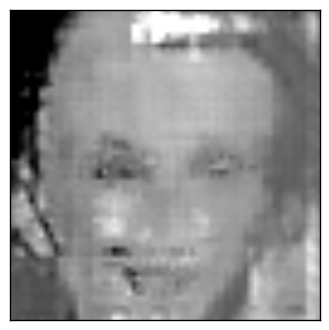

Step: 23401, disc loss: 14.0515232086, disc accuracy: 0.8125


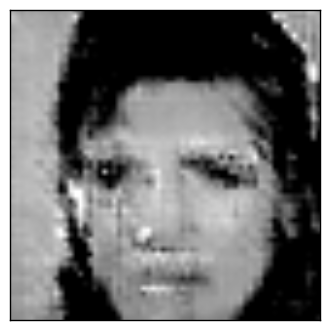

Step: 23601, disc loss: 14.904624939, disc accuracy: 0.75


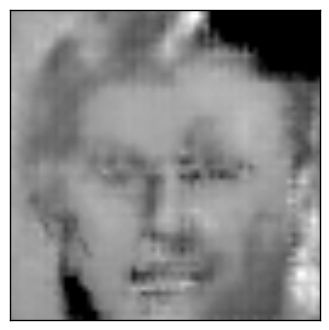

Saved
Step: 23801, disc loss: 14.9134759903, disc accuracy: 0.78125


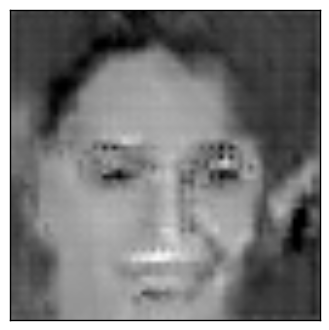

Step: 24001, disc loss: 16.8949661255, disc accuracy: 0.71875


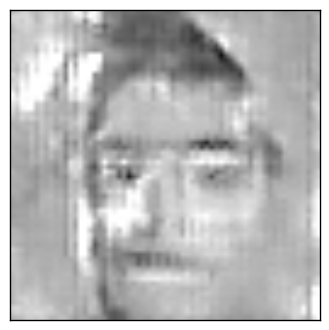

Step: 24201, disc loss: 10.3960189819, disc accuracy: 0.9375


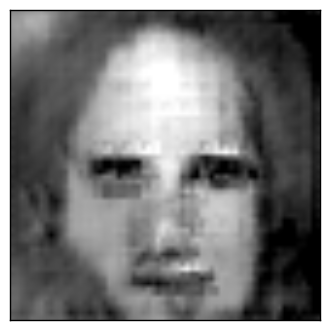

Step: 24401, disc loss: 14.6942596436, disc accuracy: 0.875


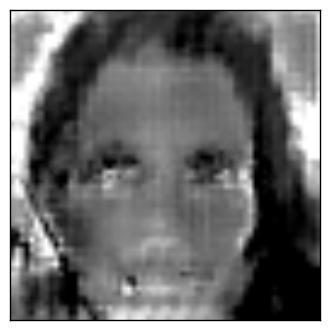

Saved
Step: 24601, disc loss: 10.6547679901, disc accuracy: 0.875


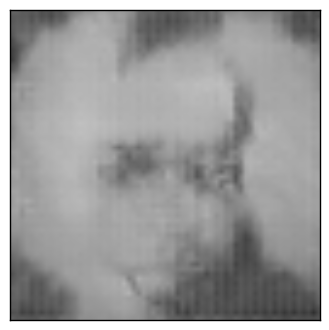

Step: 24801, disc loss: 10.9937782288, disc accuracy: 0.84375


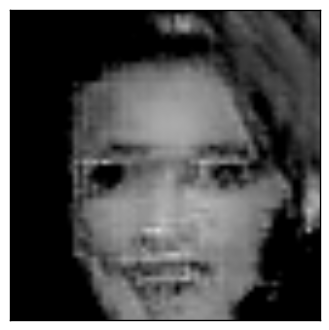

Step: 25001, disc loss: 14.0035991669, disc accuracy: 0.78125


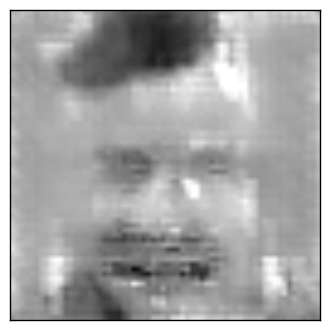

Saved
Step: 25201, disc loss: 15.5758495331, disc accuracy: 0.71875


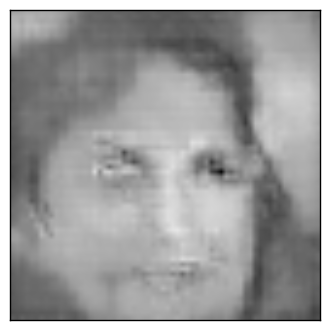

Step: 25401, disc loss: 11.5505590439, disc accuracy: 0.875


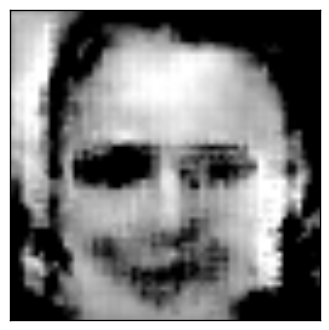

Step: 25601, disc loss: 16.478969574, disc accuracy: 0.71875


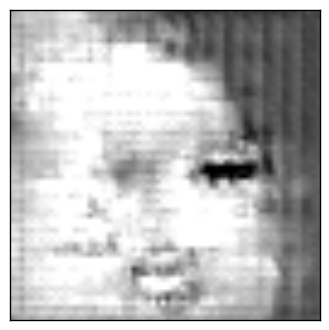

Step: 25801, disc loss: 13.8663330078, disc accuracy: 0.8125


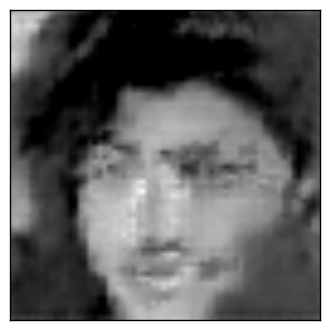

Saved
Step: 26001, disc loss: 10.6247310638, disc accuracy: 0.90625


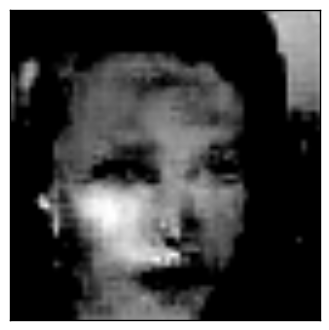

Step: 26201, disc loss: 10.246843338, disc accuracy: 0.9375


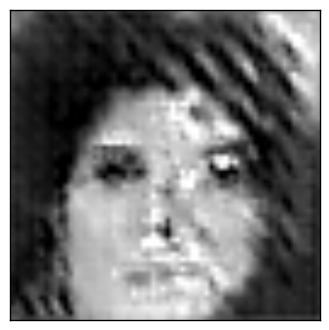

Step: 26401, disc loss: 14.5548362732, disc accuracy: 0.9375


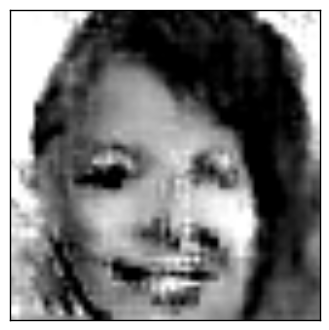

Saved
Step: 26601, disc loss: 9.65540313721, disc accuracy: 0.9375


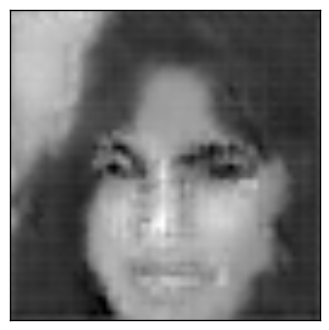

Step: 26801, disc loss: 12.0767793655, disc accuracy: 0.84375


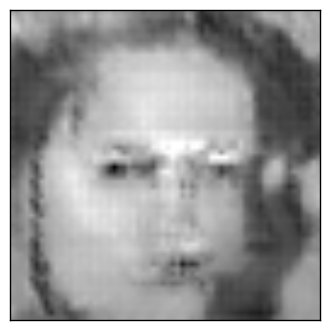

Step: 27001, disc loss: 9.38402462006, disc accuracy: 0.9375


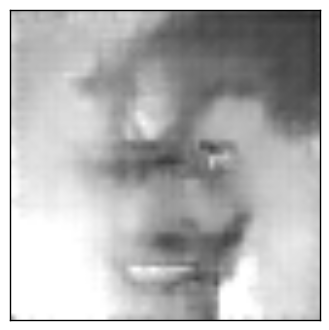

Step: 27201, disc loss: 11.7865161896, disc accuracy: 0.84375


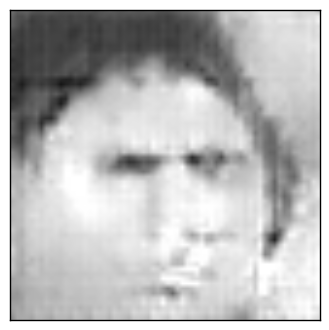

Saved
Step: 27401, disc loss: 10.3438224792, disc accuracy: 0.90625


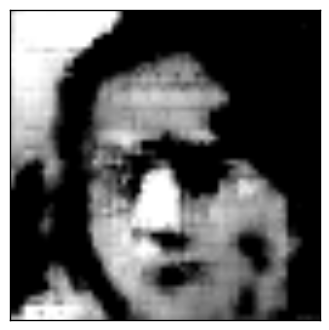

Step: 27601, disc loss: 15.6581916809, disc accuracy: 0.71875


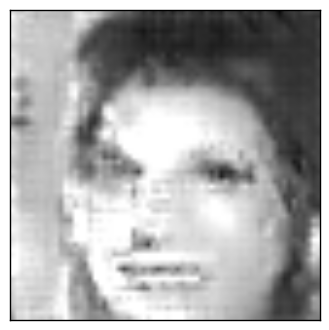

Step: 27801, disc loss: 13.0318470001, disc accuracy: 0.84375


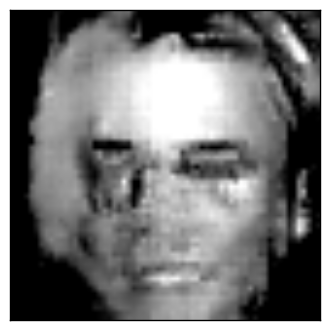

Saved
Step: 28001, disc loss: 9.93760681152, disc accuracy: 0.875


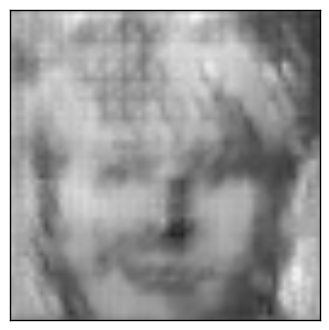

Step: 28201, disc loss: 14.5391168594, disc accuracy: 0.8125


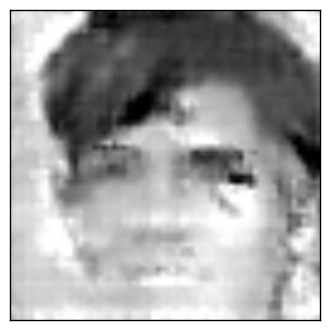

Step: 28401, disc loss: 11.0120182037, disc accuracy: 0.9375


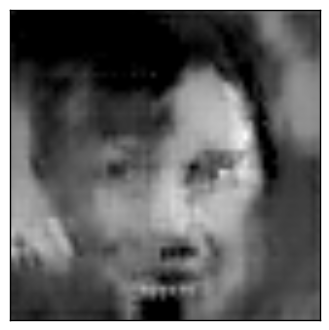

Step: 28601, disc loss: 10.5794334412, disc accuracy: 0.9375


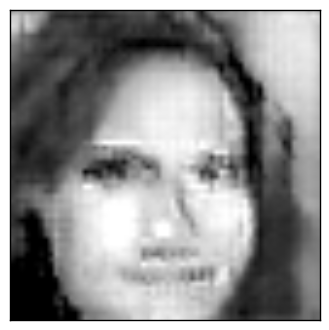

Saved
Step: 28801, disc loss: 12.7042560577, disc accuracy: 0.875


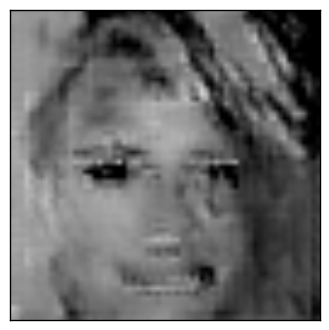

Step: 29001, disc loss: 12.2650499344, disc accuracy: 0.9375


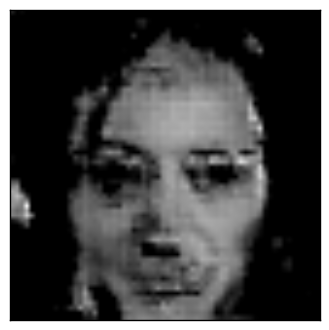

Step: 29201, disc loss: 12.3905467987, disc accuracy: 0.84375


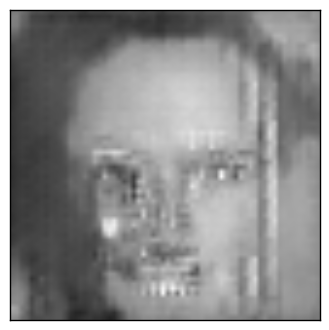

Saved
Step: 29401, disc loss: 13.2316894531, disc accuracy: 0.84375


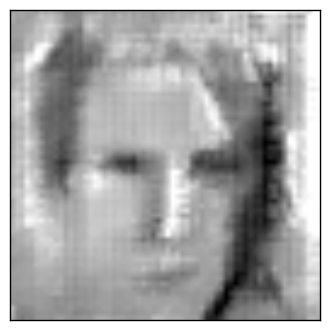

Step: 29601, disc loss: 6.03279018402, disc accuracy: 0.96875


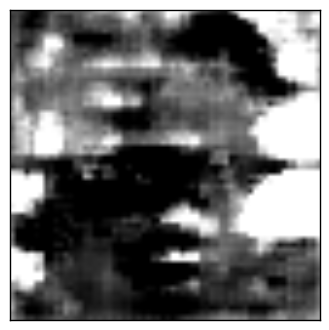

Step: 29801, disc loss: 5.93216848373, disc accuracy: 1.0


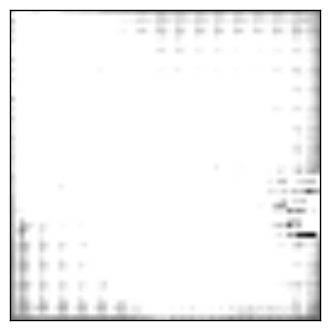

Step: 30001, disc loss: 8.91582107544, disc accuracy: 0.96875


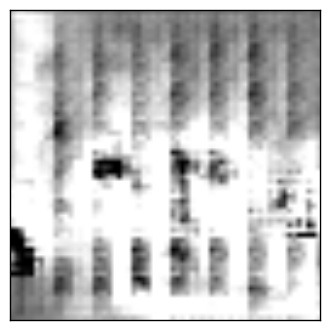

Saved
Step: 30201, disc loss: 10.6563854218, disc accuracy: 0.84375


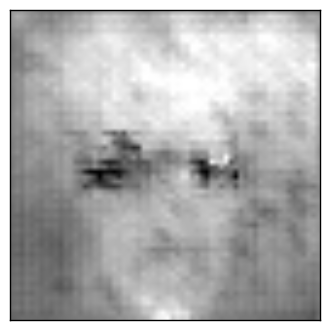

Step: 30401, disc loss: 14.9688739777, disc accuracy: 0.71875


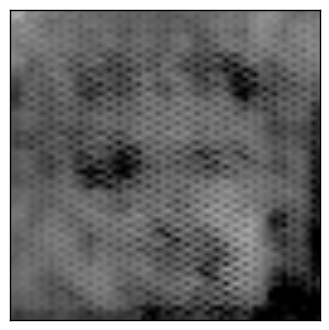

Step: 30601, disc loss: 11.3039665222, disc accuracy: 0.90625


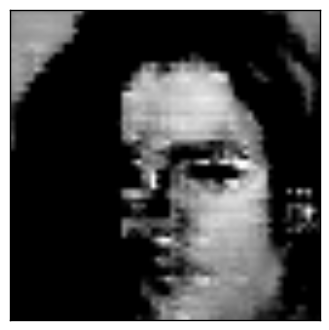

Saved
Step: 30801, disc loss: 11.0650424957, disc accuracy: 0.9375


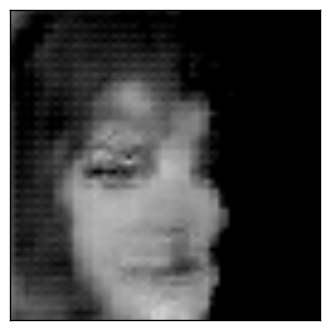

Step: 31001, disc loss: 7.94089460373, disc accuracy: 0.96875


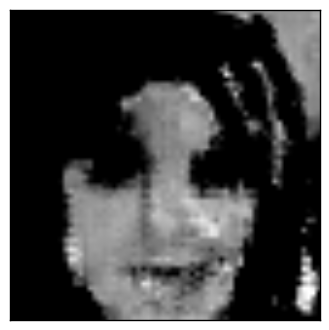

Step: 31201, disc loss: 14.5563287735, disc accuracy: 0.78125


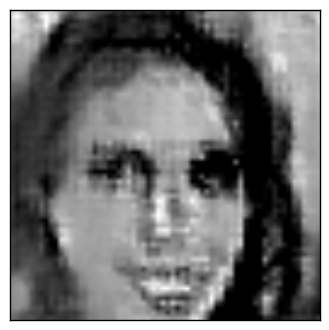

Step: 31401, disc loss: 16.2327632904, disc accuracy: 0.78125


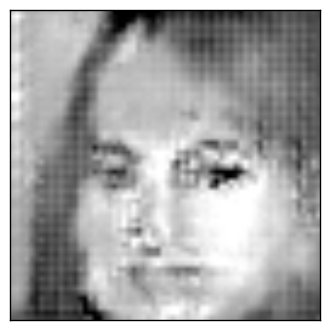

Saved
Step: 31601, disc loss: 10.3956317902, disc accuracy: 0.9375


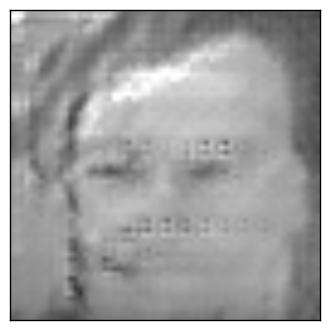

Step: 31801, disc loss: 13.4528980255, disc accuracy: 0.84375


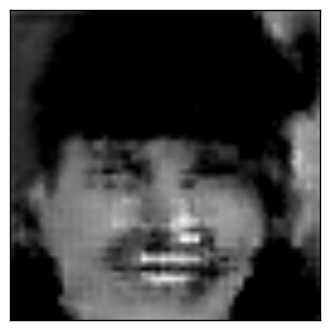

KeyboardInterrupt: 

In [ ]:
%matplotlib inline

disc_acc_ = 0.5
while True:
    TRAIN_DISC_ONLY = False
    if TRAIN_DISC_ONLY:
        disc_acc_vals = []
        step_, disc_acc_, _ = session.run([global_step, disc_accuracy, train_disc])
        disc_acc_vals.append(disc_acc_)
        if step_ % 50 == 0:
            print 'Step: {0}, acc: {1}'.format(step_, sum(disc_acc_vals) / len(disc_acc_vals))
            disc_acc_vals = []
        continue
    
    
    feed = {dropout_keep_prob: 0.5}
    
    if disc_acc_ > 0.77:
        step_, disc_acc_, _ = session.run([global_step, disc_accuracy, train_gen], feed_dict=feed)
    else:
        step_, disc_acc_, _ = session.run([global_step, disc_accuracy, train_disc], feed_dict=feed)
        
    # step_, diff_loss_, disc_loss_, diff_loss_weight_, _, img_, disc_acc_ = session.run(
    #    [global_step, generated_difference_loss, discriminator_loss, diff_loss_weight, train_gen, generated[0], disc_accuracy],
    #    feed_dict=feed)
    
    # step_, img_, _, diff_loss_ = session.run([global_step, generated[0], train_reconstruction, generated_difference_loss])
    if step_ % 200 == 1:
        # diff_loss_, disc_loss_, diff_loss_weight_, img_, orig_, disc_acc_ = session.run(
        # [generated_difference_loss, discriminator_loss, diff_loss_weight, generated[0], source_batch[0], disc_accuracy],
        # feed_dict=feed)
        disc_loss_, disc_acc_, img_ = session.run([discriminator_loss, disc_accuracy, generated[0]])
        print "Step: {}, disc loss: {}, disc accuracy: {}".format(step_, disc_loss_, disc_acc_)
        # print "Step: {}, loss: {}".format(step_, diff_loss_)
        imshow_multi(np.tile([img_], [1,1,1,3]))
    if step_ % 700 == 0 and saver:
        saver.save(session, save_path + '/model.ckpt', global_step=step_)
        print 'Saved'
        